In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
import gc
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import os
gc.enable()

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
it = 10
os.makedirs('/content/drive/My Drive/Colab Notebooks/Diplom/models/bert/{0}'.format(it))

# BERT для последовательностей товаров

###Собираем эмбеддинги продуктов

In [ ]:
!pip install bert-embedding

     |████████████████████████████████| 215kB 10.3MB/s 
     |████████████████████████████████| 29.6MB 142kB/s 
     |████████████████████████████████| 13.8MB 18.1MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.6.0-cp36-none-any.whl size=259916 sha256=338eada8533966bf18f59a870cdef28e6ec846f02365dd237b7f04910a4259a0
  Stored in directory: /root/.cache/pip/wheels/ff/48/ac/a77c79aa416ba6dd7bf487f2280b0471034f66141617965914
Successfully built gluonnlp
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: umap-learn 0.4.4 has requirement numpy>=1.17, but you'll have numpy 1.14.6 which is incompatible.
ERROR: tifffile 2020.6.3 has requirement numpy>=1.15.1, but you'll have numpy 1.14.6 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: spacy 2.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: plot

In [ ]:
from bert_embedding import BertEmbedding

In [ ]:
products = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/products.csv')

In [ ]:
bert_embedding = BertEmbedding(model='bert_24_1024_16', dataset_name='book_corpus_wiki_en_cased')

bert_embeddings = {}

for ind in tqdm(products.index, position=0):
  bert_embeddings[products.loc[ind, 'product_id']] = np.mean(bert_embedding([products.loc[ind, 'product_name']])[0][1], axis=0)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/bert/bert_embeddings.pkl', 'wb') as f:
  pkl.dump(bert_embeddings, f)

100%|██████████| 49688/49688 [7:54:03<00:00,  1.75it/s]


###Считываем данные и подготавливаем выборку

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/bert/bert_embeddings.pkl', 'rb') as f:
  bert_embeddings = pkl.load(f)

###Понижаем размерность векторов bert

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1).drop_duplicates(subset=['uxp_total_bought', 'uxp_reorder_ratio',
       'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases', 'p_reorder_ratio', 'order_dow',
        'order_hour_of_day', 'days_since_prior_order'])
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
bert_matrix = np.zeros((len(id_to_token), 1024))
for i_d, token in id_to_token.items():
  bert_matrix[i_d, :] = bert_embeddings[token]

In [ ]:
pca = PCA(n_components=13, random_state=432)

bert_matrix_red = pca.fit_transform(bert_matrix)

In [ ]:
bert_to_df = np.zeros((bert_matrix_red.shape[0], bert_matrix_red.shape[1] + 1))
for i_d, token in id_to_token.items():
  bert_to_df[i_d, 0] = token
  bert_to_df[i_d, 1:] = bert_matrix_red[i_d, :]

In [ ]:
bert_df = pd.DataFrame(bert_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train.merge(bert_df, how='inner', on='product_id')
new_data_val = data_val.merge(bert_df, how='inner', on='product_id')
new_data_test = data_test.merge(bert_df, how='inner', on='product_id')

prods_df = train_positive.merge(bert_df, how='inner', on='product_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Обучаем и проверяем качество на валидации

100%|██████████| 6605/6605 [05:15<00:00, 20.93it/s]




{1: 0.48122634367903105, 2: 0.4359197577592733, 3: 0.4026495079485217, 4: 0.3746341155690134, 5: 0.352681049709801, 6: 0.3343313146606086, 7: 0.3196851231030002, 8: 0.30694450452398975, 9: 0.29640955625248927, 10: 0.28644235968421294}
{1: 0.087390194022105, 2: 0.14594789785444218, 3: 0.19418593609361773, 4: 0.23257954499533456, 5: 0.26668812369325506, 6: 0.2973407374121092, 7: 0.3257404696573826, 8: 0.3514885466912944, 9: 0.3752284157517415, 10: 0.39678676484639247}


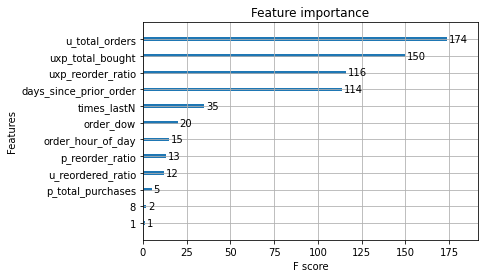

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

100%|██████████| 6605/6605 [04:16<00:00, 25.72it/s]




{1: 0.4579168612797758, 2: 0.42013078000934145, 3: 0.38701541335825085, 4: 0.36469718200217977, 5: 0.3448653277284666, 6: 0.3279760236649498, 7: 0.31586330375215016, 8: 0.3043716776762081, 9: 0.2941103771416755, 10: 0.28511042903849315}
{1: 0.08033265559484569, 2: 0.13648739843156585, 3: 0.1816234358490413, 4: 0.22269655515816544, 5: 0.2575154265682493, 6: 0.28686268710062857, 7: 0.3162930935369601, 8: 0.3424345674304845, 9: 0.3660974473568904, 10: 0.3873746232290391}


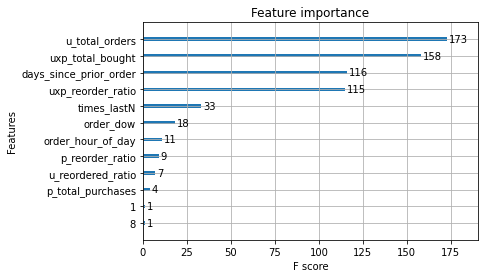

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_bert_feats = {}

metric_with_bert_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/bert/{0}/metric_with_bert_feats.pkl'.format(it), 'wb') as f:
  pkl.dump(metric_with_bert_feats, f)